# 0이냐 1이냐 혹은 /긍정/부정을 판단하는 이진 분류에서는 
# 정확도보다는 다른 성능 평가 지표가 더 중요시되는 경우가 많다.

## 분류의 성능평가지표는 다음과 같다 (이진분류/멀티분류에 다 쓸 수 있는 지표이지만, 2진분류에서 더욱 중요하게 강조되는 지표이다)
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

# 1. 정확도(Accuracy)
# 정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
 
 ## 하지만, 정확도 지표는 ML 모델의 성능을 왜곡할 수 있다.
 ### 아래의 BaseEstimator와 MyDummyClassifier 클래스 예제로 확인가능

In [1]:
# fit() 메서드 역할 X, 에측 수행하는 predict()메서드는 단순히 Sex 피처가1 이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier이다.

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
                
        return pred

In [2]:
# 위에서 생성된 MyDummyClassifier를 사용해 타이타닉 데이터를 학습/예측/평가 해본다

# 지금까지 피처를 가공한 내역을 정리하고, 이를 함수로 만들어 쉽게 재사용 제작
## 데이터 전처리 전체 호출 함수 : transform_features()   : Null처리, 포매팅, 인코딩 수행

In [3]:
#########################################################################################################
from sklearn import preprocessing

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df


# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


# Label인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()  # 오탈자. le = LabelEncoder() 라고만 되어 있었음.
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


# 앞에서 설정한 데이터전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

#########################################################################################################

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)   # 이전 학습했던 전처리 부분 재 사용
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))
                                                              
# 단순히 Sex 피처가1 이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier이다.
# 남자는 다 죽고, 여자는 살리는 걸로만 예측해서 80% 생존이라는 결과치를 뽑아내는 엉망인 케이스를 보여주는 예제.

Dummy Classifier의 정확도는: 0.7877


# 위와 같이, 정확도는 특히 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다. 
# 예를 들어, 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0,
# 10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 된다.

### 아래는 MNIST 데이터 셋을 이용한 테스트다. Multi Classification에서 Binary Classification으로 변경한다.
## 7만 True고 나머지 숫자는 False로 둬서 정확도 예측 테스트 시작.

#### 아무것도 하지 않고 무조건 특정한 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있는 것이 정확도 평가 지표(Accuracy)의 맹점이다.

In [7]:
from sklearn.datasets import load_digits # MNIST 데이터 로딩 내장 데이터 셋
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()


# digits 번호가 7번 이면, Ture이고, 이를 astype(int)로 1로 변환(숫자형식), 나머지는 False이고 int형식 0으로 변환.
y = (digits.target == 7).astype(int)  # 7을 int 형식으로 변환. 즉 1을 가짐
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [8]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())   # 잘 이해 안됨

#테스트 세트 레이블 0 과 1의 분포도
# 0    405
# 1     45
# dtype: int64

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)   #    def predict(self, X):
print('모덴 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모덴 예측을 0으로 하여도 정확도는:0.900


# 정확도(Accuracy)가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 한다.

# 2.  오차 행렬(Confusion Matrix)
## 이진 분류에서 성능 지표로 잘 활용됨. True  /  False,  Positive  /  Negative 4분면으로 구성

# matrix를 2x2 로 나누어서 각각   TN / FP / FN / TP  로 표시
여기서 P 와 N 의 의미는 예측을  Positive(1) 로 했는지, Negative(0) 로 했는지를 의미하고, 
앞쪽의 T 와 F 는 실제값으로, 실제 클래스와 예측 클래스가 맞았는지(True), 틀렸는지(False)를 의미합니다.
#            Negative(0으로 예측)       Positive(1로 예측)
# Negative(실제)       TN(True는 둘 다 동일)                      FP
# Positive(실제)       FN                      TP(True는 둘 다 동일)

### 정확도 예제에서 다룬 MyFakeClassifier의 예측 성능 지표를 오차 행렬로 표현
#### 예측결과 : fakepred와 실제결과 : y_test를 사용

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) # 예측결과 : fakepred와 실제결과 : y_test를 사용

# TN 405, FN  45. 나머지 FP TP는 0 결과값 

# TN 은 array[0,0]. FP [0.1] , FN [1,0], TP [1,1] 표현가능

array([[405,   0],
       [ 45,   0]], dtype=int64)

In [10]:
## 앞 클래스는 무조건 Negative로 예측하면 Classifier였고, 테스트 데이터 세트의 클래스 값 분포는 0이 405건, 1이 45건이다.

# 풀어보면, TN : 예측 : Negative(7이 아닌 Digit) / 실제 : Negative(7이 아닌 Digit) 총 405개
#           FN : 예측 : Negative(7이 아닌 Digit) / 실제 : Positive(7만) 45개
#           FP : 예측 : Positive(7만)   /   실제 : egative(7이 아닌 Digit) 0개
#           TP : 예측 : Positive(7만)   /   실제 : Positive(7만) 0개

#### 즉, 정확도는 다믕과 같이 재정의될 수 있다.
# 정확도 : 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)

### - 이렇게 보다시피, 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Positive 보다는 Negative로 예측 정확도가 높아지는 경향이 발생함.
### - 사기 행위 예측이나 암 검진 예측 모델에서는 양성 경우 1, 음성 경우 0을 할당하는 경우가 매우 많음
### - 대표적인 불균형 이진분류 데이터이다. 9,900건이 Negative, 100건이 Positive인 경우......
### - 이런경우, Negative로 에측하는 경우가 더 강해져서 TN은 매우 커지고, TP는 매우 작아지게 된다.
### - 결과적으로 정확도 지표는 비대칭 데이터에서는 Positive에 대한 예측 정확도를 판단하지 못한 채, Negative에 대한 예측 정확도 만으로 분류의 정확도가 매우 높게 나타나는 '수치적인 판단 오류' 를 일으키게 된다.

# 3. 정밀도와 재현율

## Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표.

### - 정밀도 = TP / (FP + TP) (양성 예측도 라고도 불림). '예측'을 Positive로 한 대상 중에 예측과 실제값이 일치한 데이터 비율.  FP을 낮추는 데 초첨. TP를 올리는 데 초첨. 1으로 예측하는 게 더 많아질수록(0.5 초과 임계값등..) 정밀도 상승
    -> FP + TP는 예측을 Positive로 한 모든 건수
    -> 정밀도가 중요한 지표는 실제 Positive 양성을 Negative로 잘못 판단하게 될 경우.
     -> 스팸 메일 분류 모델.
     
### - 재현율 = TP / (FN + TP) (민감도 또는 True Positive Rate 라고도 불림) 실제 Positive(1)이 정확히 예측되야 하는 수준.  FN을 낮추는 데 초첨.  TP를 올리는 데 초첨. 양성예측이 많을 수록 재현율은 상승

#### -- 특이성(Specificity, TN Rate) : 민감도에 대응하는 지표로, 실제 Negative(0)이 정확히 예측되야 하는 수준. (건강한 사람은 질병이 없다로 음성 판정)
    -> ### FPR = FP / (FP + TN) = 1- TNR = 1 - 특이성
    -> FN + TP는 실제값이 Positive로 한 모든 건수
    -> 정밀도가 중요한 지표는 실제 Positive 양성을 Negative로 잘못 판단하게 될 경우.
     -> 암 판단 모델, 금융사기적발 모델 등.

##### 정밀도 : precision_score()   /   재현율 : recall_score() 사용

In [11]:
# 오차행렬, 정확도, 정밀도, 재현율을 한 번에 불러오기 위해 get_clf_eval 함수 제작

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)   # 오차행렬
    accuracy = accuracy_score(y_test,pred)  # 정확도
    precision = precision_score(y_test,pred) # 정밀도
    recall = recall_score(y_test,pred) # 재현율
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [12]:
# 로지스틱 회귀로 타이타닉 생존자 예측 및 평가 수행
from sklearn.linear_model import LogisticRegression


# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)


X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)


lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


C:\Users\fu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# 재현율 또는 정밀도를 좀 더 강화할 방법은?

## 1. 정밀도/재현율의 Trade-off
 -> 상호 보완적인 평가지표 이므로 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지는걸 이용.
   -> 이 과정에서 임곗값을 조정 (기본은 0.5)

#### 이 과정에서. 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()로 예측 확률 확인과, Binarizer로 임곗값 조정
 -> ndarray m(입력값의 레코드 수 ) x n(클래스 값 유형. 이진분류시 2) 반환.
    -> 첫 번째 칼럼은 0 Negative 확률, 두 번째 칼럼은 1 Positive 확률

In [13]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.4493523  0.5506477 ]
 [0.86335514 0.13664486]
 [0.86429647 0.13570353]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4493523  0.5506477  1.        ]
 [0.86335514 0.13664486 0.        ]
 [0.86429647 0.13570353 0.        ]]


In [14]:
 # 정밀도 / 재현율 트레이드 오프 방식을 이용하고 임곗값 조정을 활용하기 위해 Binarizer 사용
 # 아래는 Binarizer 사용법 익히기 위한 테스트
    
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X 의 개별 원소들이 임곗값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
# predict()가 predict_proba()(예측확률) 에 기반해서 미리 지정된 (기본은 0.5) 임곗값보다 크면 1, 작으면 0을 반환하는(그쪽으로 치우친다는걸) 보여주는 아래 코드

from sklearn.preprocessing import Binarizer
# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)


binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 결괏값은 위의 로지스틱 회귀로 계산된 지표값과 정확히 일치함을 확인

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [16]:
# 임곗값을 0.4로 낮춰보기

# Binarizer의 threshold 설정값을 0.4로 설정. 즉, 분류 결정 임곗값을 0.5 -> 0.4로 낮춤
custom_threshold = 0.4   # 0.4로 낮춤
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)   # Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


## 임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어진 이유는, 확률이 0.5가 아닌 0.ㅣ4부터 Positive로 예측을 너그럽게 하므로 임겟값을 낮출수록 Ture 값이 만아지게 된다.

# 임곗값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

In [18]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):   # pred_proba_c1 새로이 추가
    # thresholds list객체 내의 값을 차례로 iteration(반복)하면서 Evauation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)  # fit으로 x_test 값에 해당하는 pred_proba_c1 사용
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)   # 값 반환.

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


# 사이킷런의 precision_recall_curve() API 활용해 위와 같은 것 구현하기
 -> y_true : 실제 클래스값 배열 파라미터 (배열크기 = [데이터 건수])
    probas_pred: Positive 칼럼 예측 확률 배열 파라미터

## 0.11~0.95 정도의 임곗값을 담은 넘파이 ndarray와 이 임곗값에 해당하는 정밀도 및 재현율 값을 담은 넘파이 ndarray를 반환

## 또한, 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화하는 데 이용할 수 있다.

In [29]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 (TP)
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)


# 반환된 임계값 배열 ROW가 147건 이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)  # 15 지정 안하면 TP 값이 147개 이므로, 147개가 모두 출력됨.
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))  # 소숫점 2자리 까지 나타냄


# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 구현
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index],3 ))   # 임곗값 0.49 일때 결과가 가장 좋음.

반환된 분류 결정 임곗값 배열의 Shape: (147,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도:  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


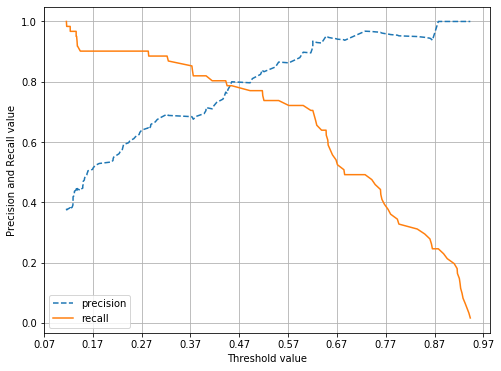

In [43]:
# 정밀도와 재현율 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1 )
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행.
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') # 정밀도는 점선으로 표시
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:,1])  # [:,1] 는 index 범위 지정

# 위의 결과에선 약 0.45 임곗값 지점에서 재현율과 정밀도가 비슷해 지는 모습
## 위처럼 Positive 예측의 임곗값 변경에 따라 각 수치가 변경된다. 둘을 상호 보완할 수 있는 수준에서 적용해야 한다

### 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주 가능. 그래서 아래의 평가 스코어를 추가로 써야 한다.

# 2. F1 스코어 
## 정밀도와 재현율을 결합한 지표. 둘이 어느 한쪽으로 치우치지 않는 수치를 나타낼 대 상대적으로 높은 값을 가짐.
### 공식 : F1 = 2 / 1 / recall + 1 / precision              =  2 * precision * recall / precision + recall

 -> 사이킷런은 f1_score() API 제공

In [45]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred) # f1 스코어 API
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [58]:
# 앞서 구현한 get_clf_eval() 함수에 F1 스코어를 구하는 로직을 추가해 임곗값 변화시키며 평가지표 구함.


def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)   # 오차행렬
    accuracy = accuracy_score(y_test,pred)  # 정확도
    precision = precision_score(y_test,pred) # 정밀도
    recall = recall_score(y_test,pred) # 재현율
    
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    # F1 스코어 추가완료
    print('오차 행렬')
    print(confusion)
    # F1 스코어 print
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)  # 피쳐들의 예측값
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1: 0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1: 0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1: 0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1: 0.8000


# 임곗값: 0.45 일때 가 정밀도와 재현율이 균형을 이룬다. 하지만 0.60 일때 F1 스코어는 가장 높으니, 정밀도와 재현율을 따로 구하는게 가장 좋을 것이라 생각한다.
    임곗값: 0.45
    오차 행렬
    [[105  13]
     [ 13  48]]
    정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1: 0.7869
                
     임곗값: 0.6
    오차 행렬
    [[113   5]
     [ 17  44]]
    정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1: 0.8000


# 3. ROC 곡선과 AUC
## 이것은 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표.
## ROC 는 FP Rate(X축)가 변할때 TP Rate(재현율, Y축)는 어떻게 변하는지 나타내는 곡선
### FPR = FP / (FP + TN) = 1- TNR = 1 - 특이성 은 가운데 직선의 기준. 즉 0.5가 기본 (임곗값 설정 기준)

    -> 사이킷런은 roc_curve() API 제공
        -> y_ture: 실제 클래스 값 array 파라미터 ( array shape = [데이터 건수])
        -> y_score: predict_prob()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨. array.shape = [n_smaples]

In [51]:
# 타이타닉 생존자 예측 모델의 FPR, TPR 임곗값을 구해보기

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열 ROW가 147건 이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 5)  # 5 지정 안하면 TP 값이 147개 이므로, 147개가 모두 출력됨.
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))  # 소숫점 2자리 까지 나타냄


# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))   

샘플 추출을 위한 임계값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45]
샘플용 10개의 임곗값:  [1.94 0.87 0.63 0.55 0.44 0.32 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.059 0.127 0.203 0.559 0.602 0.695 0.847]
샘플 임계값별 TPR:  [0.    0.246 0.672 0.738 0.787 0.885 0.902 0.951 0.967 0.984]


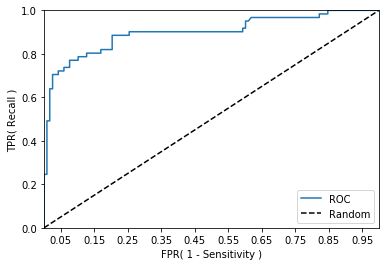

In [52]:
# FPR, TPR 임곗값 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

## 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용한다.
## - 분류의 성능 지표는 ROC 곡선 면적에 기반한 AUC(Area Under Curve) 값이다. 
    -> ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다.
### - 1) 가운데 직선에서 멀어지고, 2) 왼쪽 상단 모서리쪽으로 가파르게 곡선이 이동해 3) 직사각형에 가까운 곡선이 되면 4) 면적 1에 가까워지는 좋은 ROC AUC 성능수치를 얻는다.    
    -> 가운데 대각선 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5이다. (보통의 분류는 0.5 이상의 AUC 값을 가진다)
    
#### AUC 수치가 커지려면 FRP가 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐 이다.
    -> 사이킷런은 roc_auc_score() API 제공

In [56]:
# 로지스틱 회귀 타이타닉 예측 모델의 ROC AUC 구하기

from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8429


In [60]:
# 앞서 구현한 get_clf_eval() 함수에 ROC AUC 값을 구하는 로직을 추가해 임곗값 변화시키며 평가지표 구함.


def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)   # 오차행렬
    accuracy = accuracy_score(y_test,pred)  # 정확도
    precision = precision_score(y_test,pred) # 정밀도
    recall = recall_score(y_test,pred) # 재현율
    f1 = f1_score(y_test, pred)    # F1 스코어 추가
    roc_score = roc_auc_score(y_test, pred)  # ROC AUC 값 추가
    print('오차 행렬')
    print(confusion)
    # 모든 Score 출력
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_score))
    
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)  # 피쳐들의 예측값
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1: 0.7576, ROC AUC: 0.8209
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1: 0.7869, ROC AUC: 0.8384
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1: 0.7966, ROC AUC: 0.8429
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1: 0.7965, ROC AUC: 0.8392
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1: 0.8000, ROC AUC: 0.8395


# 임곗값: 0.45 일때 결과가 가장 좋은 것 같은데, 임곗값을 조정하는 것으로서 해결될까?
    오차 행렬
    [[97 21]
     [11 50]]
    정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1: 0.7576, ROC AUC: 0.8209

    임곗값: 0.45
    오차 행렬
    [[105  13]
     [ 13  48]]
    정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1: 0.7869, ROC AUC: 0.8384

    임곗값: 0.5
    오차 행렬
    [[108  10]
     [ 14  47]]
    정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1: 0.7966, ROC AUC: 0.8429

    임곗값: 0.55
    오차 행렬
    [[111   7]
     [ 16  45]]
    정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1: 0.7965, ROC AUC: 0.8392

    임곗값: 0.6
    오차 행렬
    [[113   5]
     [ 17  44]]
    정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1: 0.8000, ROC AUC: 0.8395